In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [60]:
def draw_graph(adj_list, positions):
    edge_coordinates = np.array([[positions[edge[0]], positions[edge[1]]] for edge in adj_list])
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(projection="3d")
    ax.scatter(*positions.T, s=100) #.T-> shape=(3, num_nodes), *-> 3 seperate lists with num_nodes elements each
    for edge in edge_coordinates: #edge shape = (2, 3)
        ax.plot(*edge.T, c="dimgrey", alpha=0.5)

In [83]:
def addShiftedCenterNodes(nx, ny, nz, shift_vec, transform, pos, mask_center_node, num_nodes):
    ind_pos_c = np.array(np.meshgrid(np.arange(0, nx), np.arange(0, ny), np.arange(0, nz)), dtype=int).T.reshape(-1, 3) #shape=(-1, 3)
    pos_c = np.array([(transform@p_c + shift_vec) for p_c in ind_pos_c])
    num_nodes += len(ind_pos_c)
    p = np.concatenate((pos, pos_c), dtype=float)
    mcn = np.concatenate((mask_center_node, np.full(shape=(len(ind_pos_c),), fill_value=True)), dtype=bool)
    return num_nodes, p, mcn

def genLatticeNodes(len_ex, len_ey, len_ez, alpha, beta, gamma, nx_max=20, ny_max=20, nz_max=20, centering_type="P"):
    e_x = len_ex*np.array([1, 0, 0], dtype=float)
    e_y = len_ey*np.array([np.cos(gamma), np.sin(gamma), 0], dtype=float)
    e_z_x = np.cos(alpha)
    e_z_y = 1/np.sin(gamma)*(np.cos(beta)-np.cos(alpha)*np.cos(gamma))
    e_z_z = np.sqrt(1-e_z_x**2 - e_z_y**2)
    e_z = len_ez*np.array([e_z_x, e_z_y, e_z_z], dtype=float)
    
    transform = np.array([e_x, e_y, e_z]).T #[1, 0, 0] -> e_x, [0, 1, 0] -> e_y, [0, 0, 1] -> e_z
    transform_inv = np.linalg.inv(transform)
    num_nodes = nx_max*ny_max*nz_max
    mask_center_node = np.full(shape=(num_nodes, ), fill_value=False, dtype=bool)
    id_diag = np.zeros(shape=(num_nodes, 2), dtype=int) #(id_node, num_diag, z)
    #indices
    ind_pos = np.array(np.meshgrid(np.arange(0, nx_max), np.arange(0, ny_max), np.arange(0, nz_max)), dtype=int).T.reshape(-1, 3) #shape=(num_nodes, 3)
    id_diag[:, 1] = ind_pos[:, 2] #z
    id_diag[:, 0] = ind_pos[:, 0] - ind_pos[:, 1] # x-y = id_diag
    #positions
    pos = np.array([transform@p for p in ind_pos])
    if centering_type=="P":
        #primitve: done
        pass
    elif centering_type=="S":
        #base-centered
        num_nodes, pos, mask_center_node = addShiftedCenterNodes(nx_max-1, ny_max-1, nz_max, 1/2*(e_x+e_y), transform, pos, mask_center_node, num_nodes)
        
    elif centering_type=="I":
        #body-centered
        num_nodes, pos, mask_center_node = addShiftedCenterNodes(nx_max-1, ny_max-1, nz_max-1, 1/2*(e_x+e_y+e_z), transform, pos, mask_center_node, num_nodes)
        
    elif centering_type=="F":
        #face-centered
        #top/bottom
        num_nodes, pos, mask_center_node = addShiftedCenterNodes(nx_max-1, ny_max-1, nz_max, 1/2*(e_x+e_y), transform, pos, mask_center_node, num_nodes)
        #left/right
        num_nodes, pos, mask_center_node = addShiftedCenterNodes(nx_max, ny_max-1, nz_max-1, 1/2*(e_y+e_z), transform, pos, mask_center_node, num_nodes)
        #front/back
        num_nodes, pos, mask_center_node = addShiftedCenterNodes(nx_max-1, ny_max, nz_max-1, 1/2*(e_x+e_z), transform, pos, mask_center_node, num_nodes)
    
    return mask_center_node, pos, transform, transform_inv, id_diag

In [115]:
def genAdjacencyList(mask_center_node, positions, transform_inv, radius, hexagonal=False, diag=list()):
    adj_list = np.empty(shape=(0, 2), dtype=int)
    pos_inv = np.array([transform_inv@p for p in positions], dtype=float)
    #print(pos_inv)
    num_nodes = len(positions)

    for n in range(num_nodes):
        node_center_pos = pos_inv[n, :]
        is_center_node = mask_center_node[n]
        dist = np.sum((pos_inv - node_center_pos)**2, axis=1)
        dist[n] = radius + 1 #-> no edges (n,n)
        if is_center_node:
            dist[mask_center_node] = 2*radius + 1 #-> no edges between center nodes
        in_sphere_ind = np.array(np.nonzero((dist < radius**2))).reshape(-1, 1)
        edges = np.concatenate((np.full(shape=(len(in_sphere_ind), 1), fill_value=n), in_sphere_ind), axis=1)
        adj_list = np.concatenate((adj_list, edges))

        if hexagonal:
           in_sphere_ind_hex = np.array(np.nonzero((dist < 2*radius**2*1.05) & (np.sum(diag==diag[n], axis=1)==2))).reshape(-1, 1)
           edges = np.concatenate((np.full(shape=(len(in_sphere_ind_hex), 1), fill_value=n), in_sphere_ind_hex), axis=1)
           adj_list = np.concatenate((adj_list, edges))
        
    return len(adj_list), adj_list

In [117]:
mask_center_node, pos, transform, transform_inv, id_diag = genLatticeNodes(1, 1, 1, np.pi/2, np.pi/2, 2*np.pi/3, nx_max=3, ny_max=3, nz_max=3, centering_type="P")
#print(id_diag.shape)
num_edges, adj_list = genAdjacencyList(mask_center_node, pos, transform_inv, 1.02, hexagonal=True, diag=id_diag)

#node_values = np.zeros(shape=(num_nodes, ))
#edge_values = np.zeros(shape=(num_edges, ))
#draw_graph(node_values, edge_values, adj_list, pos, axis=True, node_size=40)

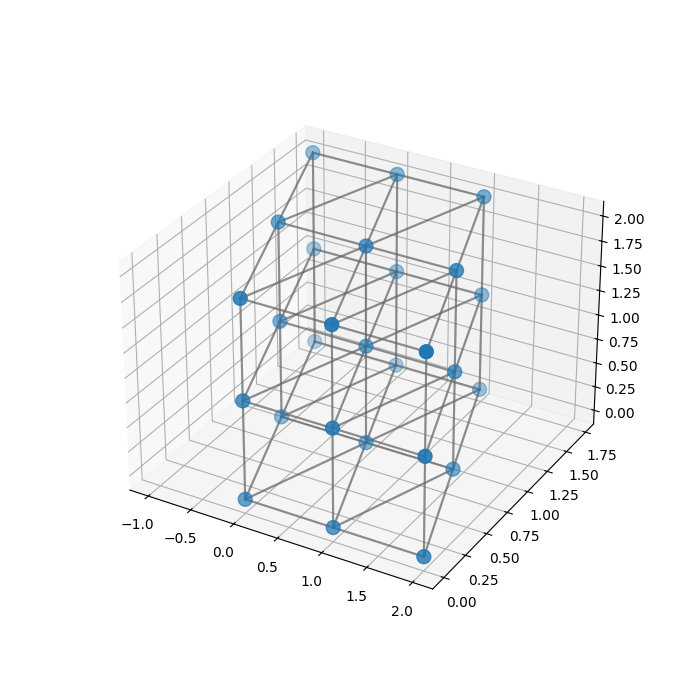

In [118]:
%matplotlib widget 
draw_graph(adj_list, pos)

In [108]:
test = np.array([[1, 2], [3, 4], [5, 6]])
np.sum(test == np.array([3, 4]), axis=1) == 2

array([False,  True, False])